<a href="https://www.kaggle.com/code/syedafraz/intrusion-detection-on-cicids2017-using-ml?scriptVersionId=284265237" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🛡️ CICIDS2017: Cleaned & Preprocessed – ML Model Benchmarking

This notebook uses the **CICIDS2017: Cleaned & Preprocessed** dataset (53 features + Attack Type).  
We train and evaluate four ML models:

- **Random Forest**
- **XGBoost**
- **Support Vector Machine (SVM)**
- **MLP Neural Network**

We evaluate each using:
- Accuracy  
- Precision  
- Recall  
- F1-score  
- Confusion Matrix  
- Feature Importance (RF + XGB)

---


In [1]:
!pip install imbalanced-learn==0.10.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
# ============================
# 📌 1. Import Libraries
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load CSV from Kaggle dataset folder
df = pd.read_csv("/kaggle/input/cicids2017-comprehensive-data-processing-for-ml/cicids2017_cleaned.csv")

df.head()


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


# 🔍 3. Dataset Overview
Let's explore shape, missing values, and class distribution.

Shape: (2520751, 53)

Missing values:
 Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Length of Fwd Packets    0
Fwd Packet Length Max          0
Fwd Packet Length Min          0
Fwd Packet Length Mean         0
Fwd Packet Length Std          0
Bwd Packet Length Max          0
Bwd Packet Length Min          0
Bwd Packet Length Mean         0
Bwd Packet Length Std          0
Flow Bytes/s                   0
Flow Packets/s                 0
Flow IAT Mean                  0
Flow IAT Std                   0
Flow IAT Max                   0
Flow IAT Min                   0
Fwd IAT Total                  0
Fwd IAT Mean                   0
Fwd IAT Std                    0
Fwd IAT Max                    0
Fwd IAT Min                    0
Bwd IAT Total                  0
Bwd IAT Mean                   0
Bwd IAT Std                    0
Bwd IAT Max                    0
Bwd IAT Min                    0
Fwd Header Length              0
Bwd 

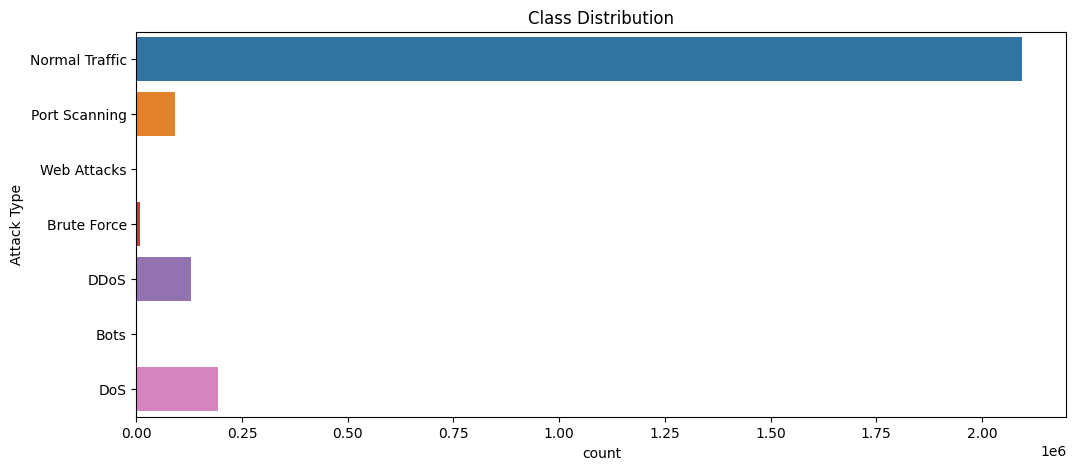

In [4]:
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

# Class distribution
plt.figure(figsize=(12,5))
sns.countplot(y=df['Attack Type'])
plt.title("Class Distribution")
plt.show()


In [5]:
# Checking the distribution of the target variable
df['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

In [6]:
# Separate features and target
X = df.drop("Attack Type", axis=1)
y = df["Attack Type"]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features (important for SVM & MLP)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Resampling

In [7]:
label_encoder.classes_


array(['Bots', 'Brute Force', 'DDoS', 'DoS', 'Normal Traffic',
       'Port Scanning', 'Web Attacks'], dtype=object)

In [8]:
normal_class_id = np.where(label_encoder.classes_ == "Normal Traffic")[0][0]
normal_class_id

4

In [9]:
# Initializing the undersampling for the clean df
X_train_resampled, y_train_resampled = RandomUnderSampler(sampling_strategy={normal_class_id: 200000}, random_state=42).fit_resample(X_train, y_train)
rus_test = RandomUnderSampler(random_state=42)
X_test_balanced, y_test_balanced = rus_test.fit_resample(X_test, y_test)

# Initializing the undersampling for the scaled df
X_train_scaled, y_train_scaled = RandomUnderSampler(sampling_strategy={normal_class_id: 200000}, random_state=42).fit_resample(X_train_scaled, y_train)
X_test_scaled_balanced, y_test_scaled_balanced = rus_test.fit_resample(X_test_scaled, y_test)

In [10]:
# Initializing the oversampling for the scaled df
X_train_resampled_scaled, y_train_resampled_scaled = SMOTE(sampling_strategy={0: 2000, 6: 2000, 1: 8000, 5: 80000, 2:130000, 3: 200000}, random_state=42).fit_resample(X_train_scaled, y_train_scaled)

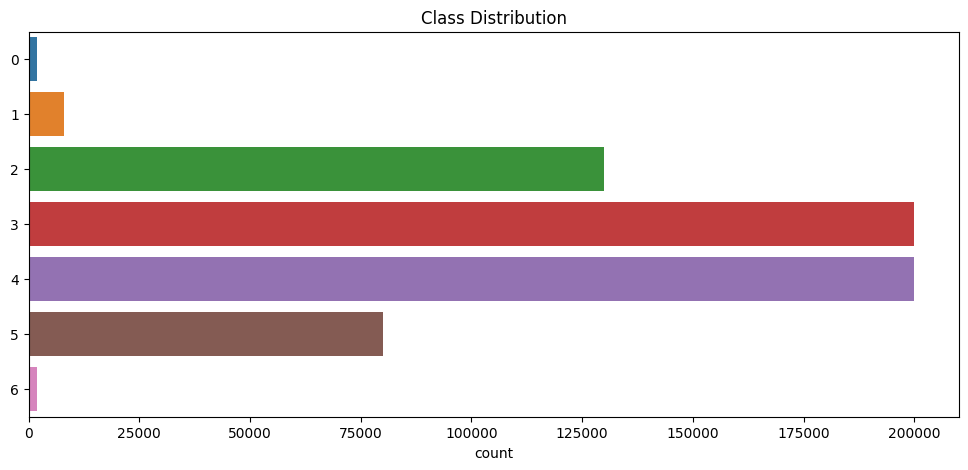

In [11]:
# Class distribution
plt.figure(figsize=(12,5))
sns.countplot(y=y_train_resampled_scaled)
plt.title("Class Distribution")
plt.show()

In [12]:
rf = RandomForestClassifier(n_estimators=20, max_depth=15, random_state=20, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)

rf_pred = rf.predict(X_test_balanced)

print("=== Random Forest ===")
print(classification_report(y_test_balanced, rf_pred, target_names=label_encoder.classes_))


=== Random Forest ===
                precision    recall  f1-score   support

          Bots       1.00      0.80      0.89       389
   Brute Force       1.00      1.00      1.00       389
          DDoS       1.00      1.00      1.00       389
           DoS       0.99      1.00      0.99       389
Normal Traffic       0.82      1.00      0.90       389
 Port Scanning       1.00      1.00      1.00       389
   Web Attacks       1.00      0.97      0.99       389

      accuracy                           0.97      2723
     macro avg       0.97      0.97      0.97      2723
  weighted avg       0.97      0.97      0.97      2723



=== Random Forest ===
Cross-validation Avg Score: 0.9983 ± 0.0001
Test Accuracy: 0.9662


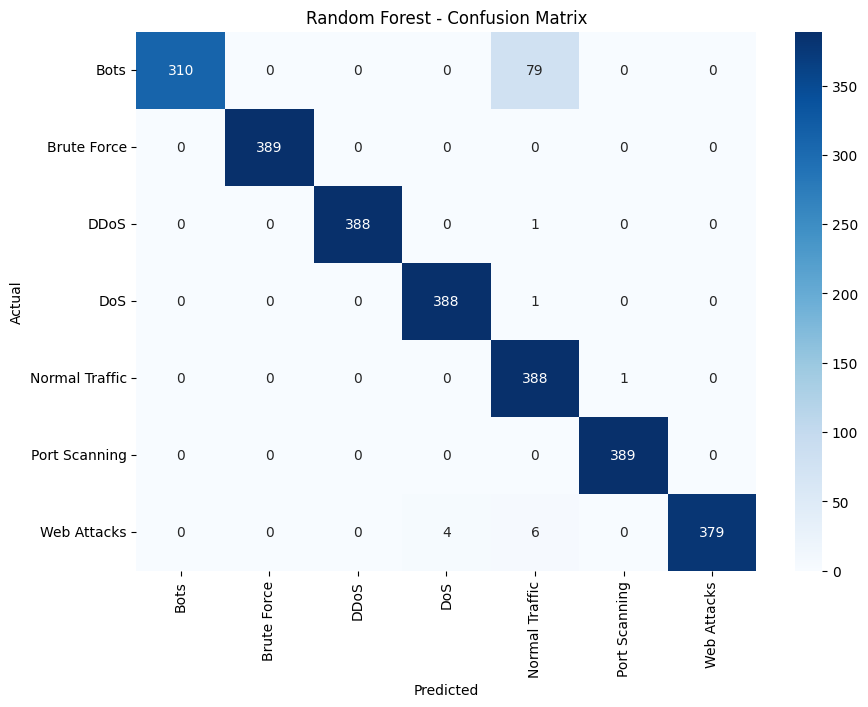

In [13]:
# === Random Forest Evaluation ===

# Cross-validation
cv_scores_rf = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=3)
cv_mean_rf = np.mean(cv_scores_rf)
cv_std_rf = np.std(cv_scores_rf)

print("=== Random Forest ===")
print(f"Cross-validation Avg Score: {cv_mean_rf:.4f} ± {cv_std_rf:.4f}")

# Accuracy
accuracy_rf = accuracy_score(y_test_balanced, rf_pred)
print(f"Test Accuracy: {accuracy_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test_balanced, rf_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.show()


In [14]:
xgb = XGBClassifier(
    n_estimators=30,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss"
)
xgb.fit(X_train_resampled, y_train_resampled)

xgb_pred = xgb.predict(X_test_balanced)

print("=== XGBoost ===")
print(classification_report(y_test_balanced, xgb_pred, target_names=label_encoder.classes_))


=== XGBoost ===
                precision    recall  f1-score   support

          Bots       1.00      0.94      0.97       389
   Brute Force       1.00      0.99      1.00       389
          DDoS       1.00      1.00      1.00       389
           DoS       0.96      1.00      0.98       389
Normal Traffic       0.88      0.99      0.93       389
 Port Scanning       1.00      1.00      1.00       389
   Web Attacks       1.00      0.90      0.95       389

      accuracy                           0.97      2723
     macro avg       0.98      0.97      0.97      2723
  weighted avg       0.98      0.97      0.97      2723




=== XGBoost ===
Cross-validation Mean: 0.9969 ± 0.0003
=== XGBoost ===
Test Accuracy: 0.9743


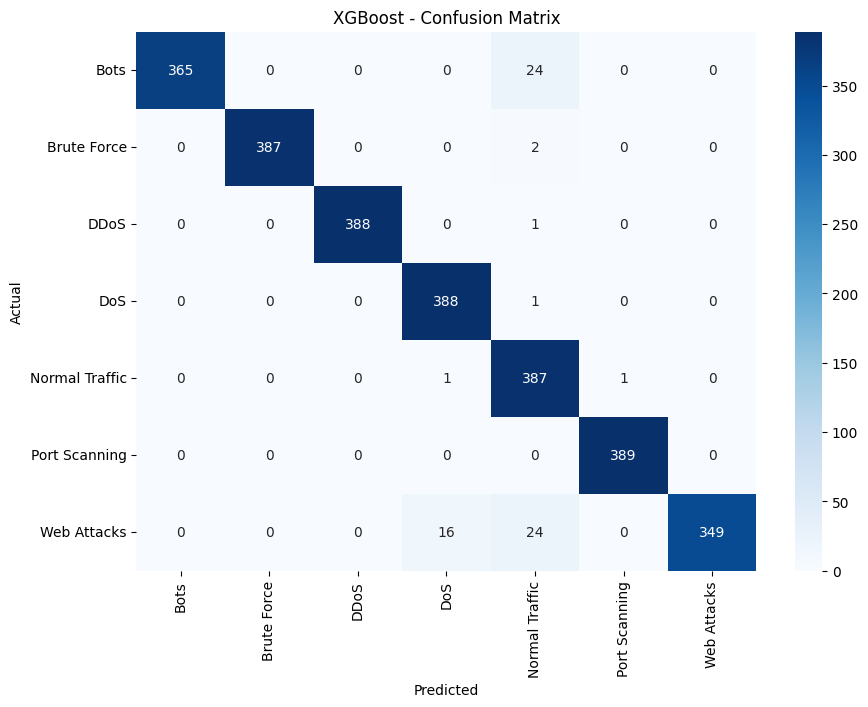

In [15]:
# === XGBoost Evaluation ===

cv_xgb = cross_val_score(xgb, X_train_resampled, y_train_resampled, cv=3)
print("\n=== XGBoost ===")
print(f"Cross-validation Mean: {cv_xgb.mean():.4f} ± {cv_xgb.std():.4f}")

accuracy_xgb = accuracy_score(y_test_balanced, xgb_pred)
print("=== XGBoost ===")
print(f"Test Accuracy: {accuracy_xgb:.4f}")

cm_xgb = confusion_matrix(y_test_balanced, xgb_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm_xgb, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost - Confusion Matrix")
plt.show()


In [16]:

svm = LinearSVC()
svm.fit(X_train_resampled_scaled, y_train_resampled_scaled)

svm_pred = svm.predict(X_test_scaled_balanced)

print("=== SVM ===")
print(classification_report(y_test_scaled_balanced, svm_pred, target_names=label_encoder.classes_))


=== SVM ===
                precision    recall  f1-score   support

          Bots       0.32      0.29      0.30       389
   Brute Force       0.99      0.99      0.99       389
          DDoS       0.88      0.75      0.81       389
           DoS       0.58      0.31      0.41       389
Normal Traffic       0.62      0.92      0.74       389
 Port Scanning       0.76      0.99      0.86       389
   Web Attacks       1.00      0.92      0.96       389

      accuracy                           0.74      2723
     macro avg       0.74      0.74      0.72      2723
  weighted avg       0.74      0.74      0.72      2723




=== SVM ===
Cross-validation Mean: 0.7361 ± 0.0831
=== SVM ===
Test Accuracy: 0.7385


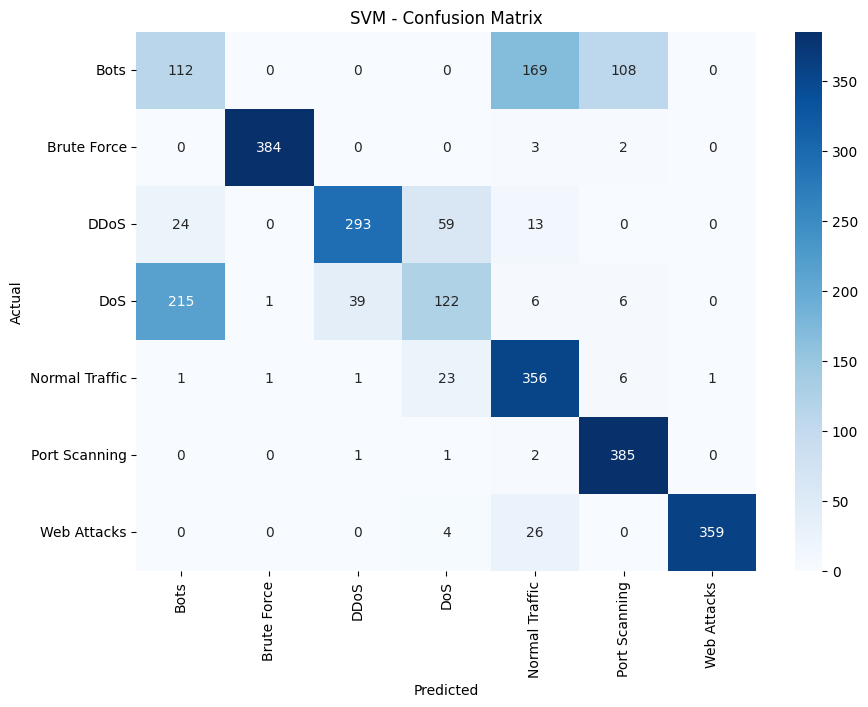

In [17]:
# === SVM Evaluation ===
cv_svm = cross_val_score(svm, X_train_resampled_scaled, y_train_resampled_scaled, cv=3)
print("\n=== SVM ===")
print(f"Cross-validation Mean: {cv_svm.mean():.4f} ± {cv_svm.std():.4f}")

accuracy_svm = accuracy_score(y_test_scaled_balanced, svm_pred)
print("=== SVM ===")
print(f"Test Accuracy: {accuracy_svm:.4f}")

cm_svm = confusion_matrix(y_test_scaled_balanced, svm_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm_svm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM - Confusion Matrix")
plt.show()


In [18]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)
mlp.fit(X_train_resampled_scaled, y_train_resampled_scaled)

mlp_pred = mlp.predict(X_test_scaled_balanced)

print("=== MLP Neural Network ===")
print(classification_report(y_test_scaled_balanced, mlp_pred, target_names=label_encoder.classes_))


=== MLP Neural Network ===
                precision    recall  f1-score   support

          Bots       1.00      0.33      0.50       389
   Brute Force       0.99      0.99      0.99       389
          DDoS       1.00      0.59      0.74       389
           DoS       0.53      1.00      0.69       389
Normal Traffic       0.67      0.82      0.74       389
 Port Scanning       0.99      0.99      0.99       389
   Web Attacks       1.00      0.98      0.99       389

      accuracy                           0.81      2723
     macro avg       0.88      0.81      0.81      2723
  weighted avg       0.88      0.81      0.81      2723




=== MLP Neural Network ===
Cross-validation Mean: 0.8446 ± 0.0011
=== MLP Neural Network ===
Test Accuracy: 0.8138


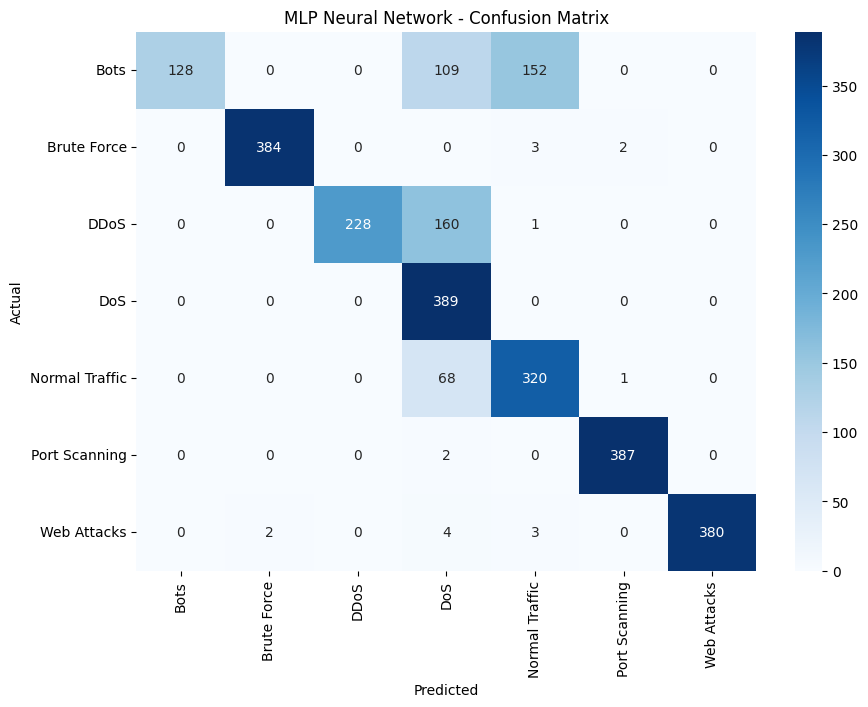

In [19]:
# === MLP Evaluation ===
cv_mlp = cross_val_score(mlp, X_train_resampled_scaled, y_train_resampled_scaled, cv=3)
print("\n=== MLP Neural Network ===")
print(f"Cross-validation Mean: {cv_mlp.mean():.4f} ± {cv_mlp.std():.4f}")

accuracy_mlp = accuracy_score(y_test_scaled_balanced, mlp_pred)
print("=== MLP Neural Network ===")
print(f"Test Accuracy: {accuracy_mlp:.4f}")

cm_mlp = confusion_matrix(y_test_scaled_balanced, mlp_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm_mlp, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MLP Neural Network - Confusion Matrix")
plt.show()


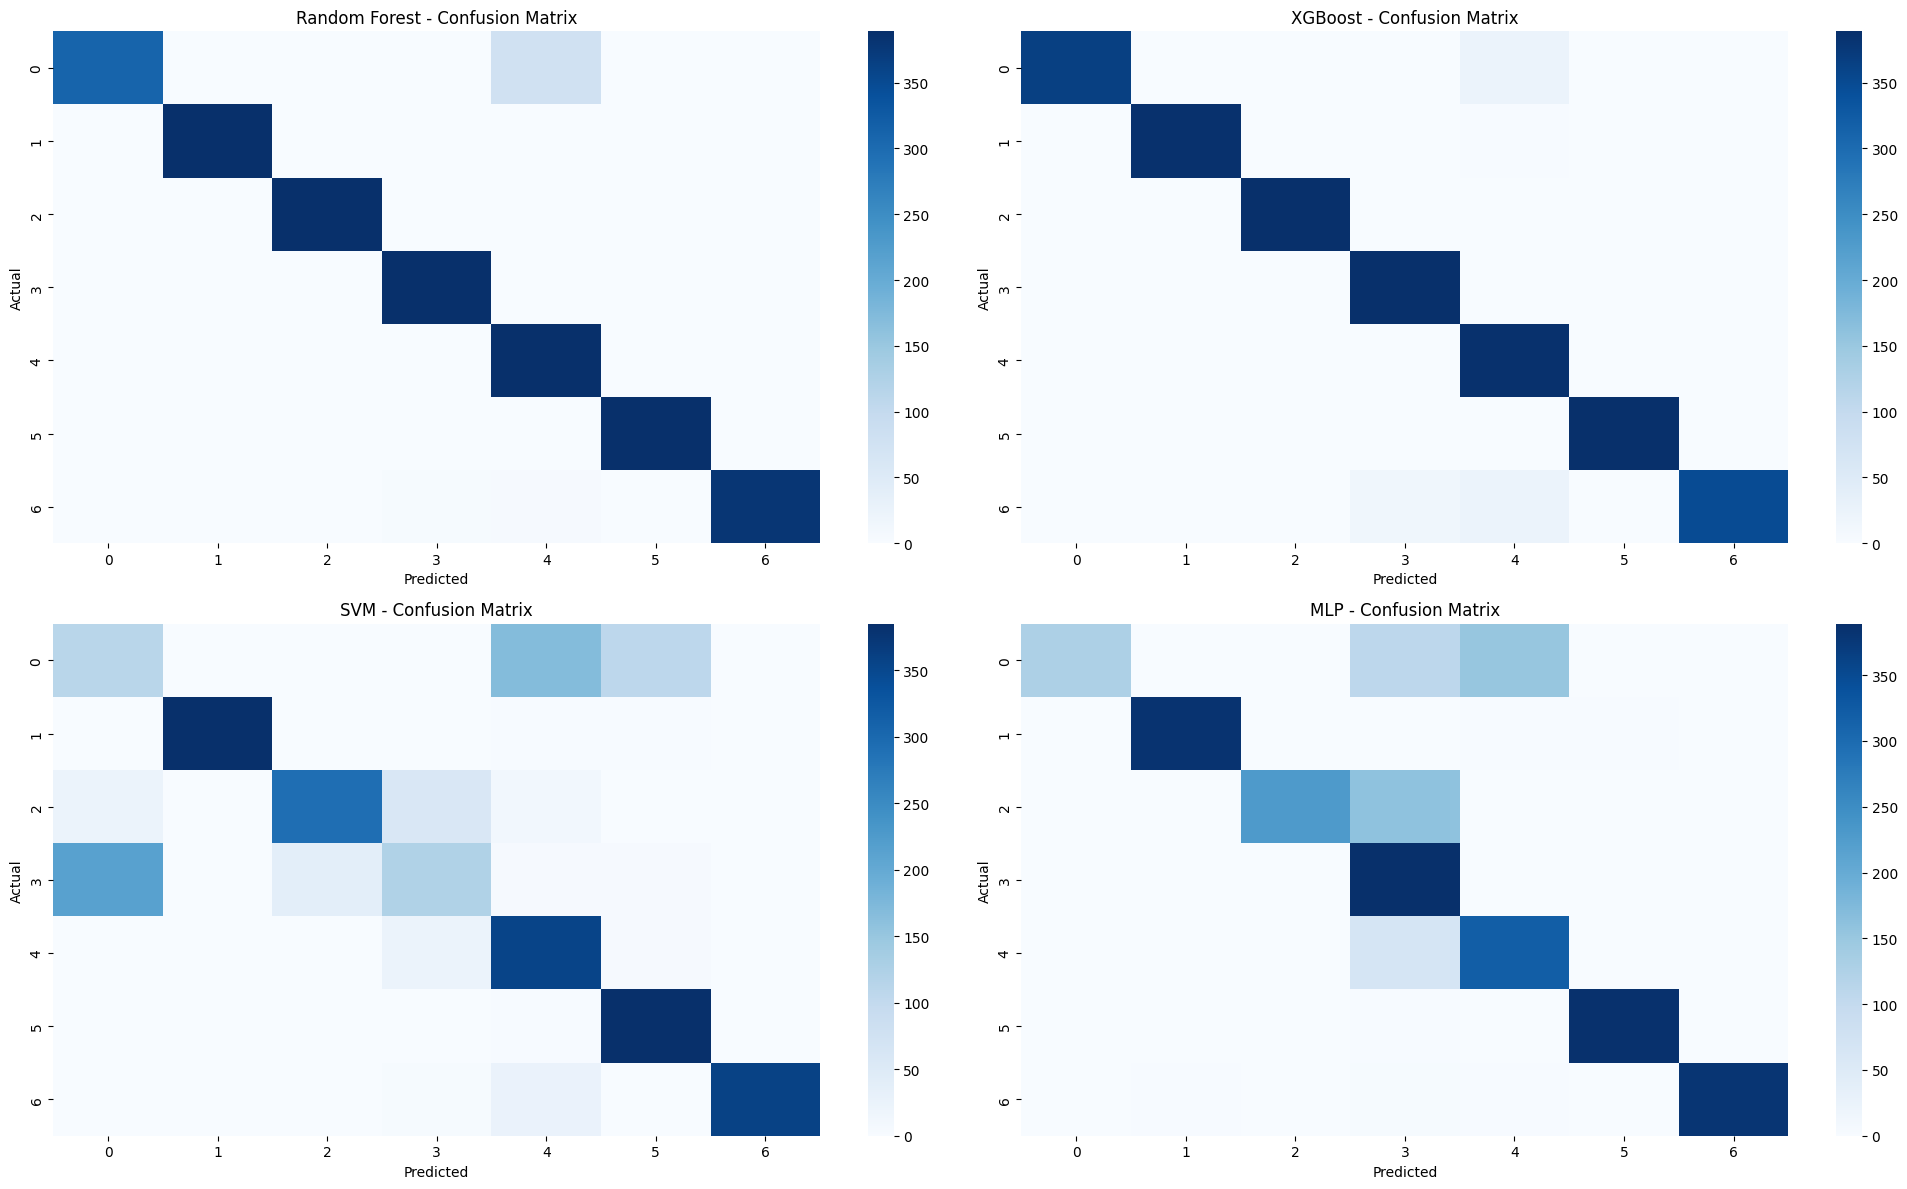

In [20]:
models = {
    "Random Forest": rf_pred,
    "XGBoost": xgb_pred,
    "SVM": svm_pred,
    "MLP": mlp_pred
}

plt.figure(figsize=(20,12))

for i, (name, pred) in enumerate(models.items(), 1):
    plt.subplot(2,2,i)
    cm = confusion_matrix(y_test_balanced, pred)
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


# ⭐ 7. Feature Importances  
Only applicable for:
- Random Forest  
- XGBoost  


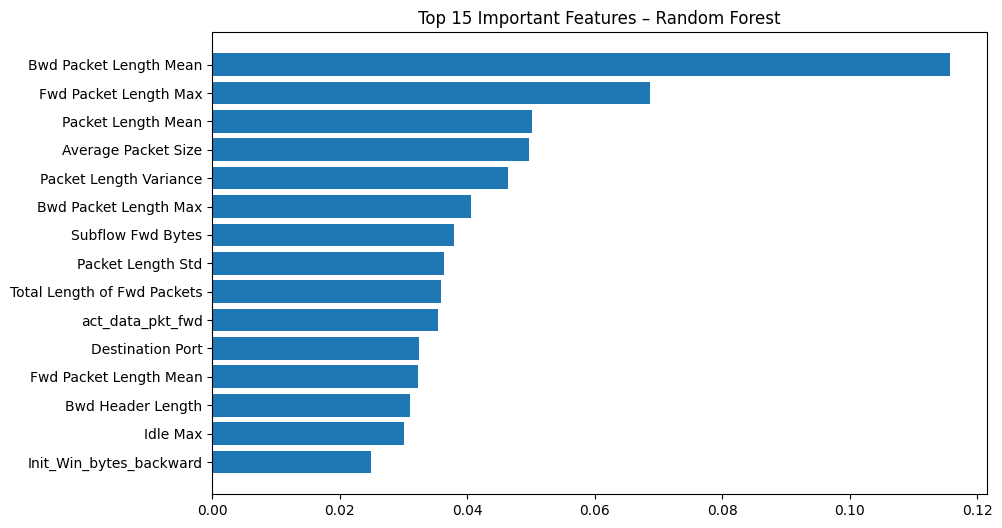

In [21]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 15 Important Features – Random Forest")
plt.show()


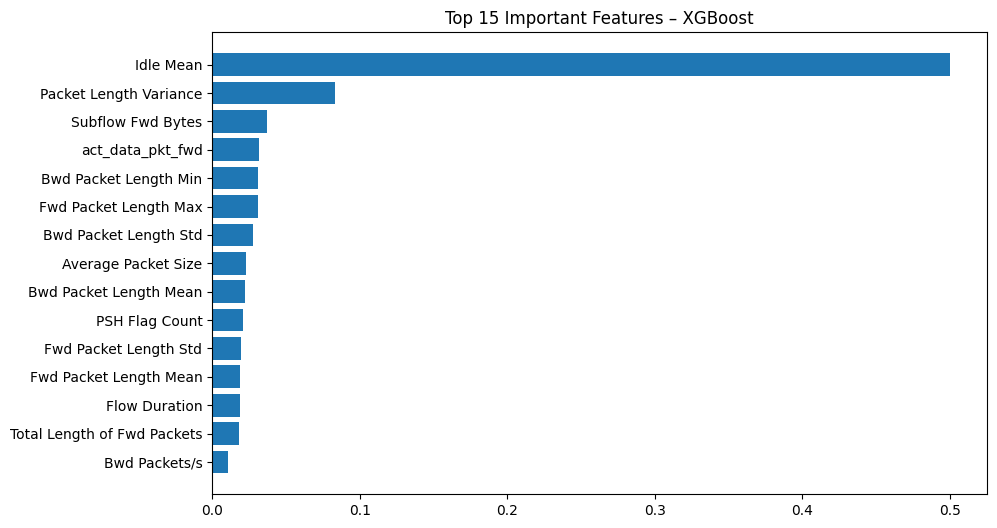

In [22]:
xgb_importances = xgb.feature_importances_
indices = np.argsort(xgb_importances)[-15:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), xgb_importances[indices], align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 15 Important Features – XGBoost")
plt.show()


In [23]:
# Calculating precision, recall, and F1 score for each model
precision_rf = precision_score(y_test_balanced, rf_pred, average='weighted')
recall_rf = recall_score(y_test_balanced, rf_pred, average='weighted')
f1_rf = f1_score(y_test_balanced, rf_pred, average='weighted')

precision_xgb = precision_score(y_test_balanced, xgb_pred, average='weighted')
recall_xgb = recall_score(y_test_balanced, xgb_pred, average='weighted')
f1_xgb = f1_score(y_test_balanced, xgb_pred, average='weighted')

precision_svm = precision_score(y_test_balanced, svm_pred, average='weighted')
recall_svm = recall_score(y_test_balanced, svm_pred, average='weighted')
f1_svm = f1_score(y_test_balanced, svm_pred, average='weighted')

precision_mlp = precision_score(y_test_balanced, mlp_pred, average='weighted')
recall_mlp = recall_score(y_test_balanced, mlp_pred, average='weighted')
f1_mlp = f1_score(y_test_balanced, mlp_pred, average='weighted')


In [24]:
results = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "SVM", "MLP"],
    "CV Mean": [
        cv_scores_rf.mean(), cv_xgb.mean(), cv_svm.mean(), cv_mlp.mean()
    ],
    "CV Std": [
        cv_scores_rf.std(), cv_xgb.std(), cv_svm.std(), cv_mlp.std()
    ],
    "Test Accuracy": [
        accuracy_rf, accuracy_xgb, accuracy_svm, accuracy_mlp
    ],
    'Precision': [precision_rf, precision_xgb, precision_svm, precision_mlp],
    'Recall': [recall_rf, recall_xgb, recall_svm, recall_mlp],
    'F1 Score': [f1_rf, f1_xgb, f1_svm, f1_mlp],
})

results


,Model,CV Mean,CV Std,Test Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.998342,0.000063,0.966214,0.972011,0.966214,0.966162
1,XGBoost,0.996933,0.000330,0.974293,0.976716,0.974293,0.974419
2,SVM,0.736092,0.083070,0.738524,0.735671,0.738524,0.724054
3,MLP,0.844643,0.001124,0.813808,0.883801,0.813808,0.805489


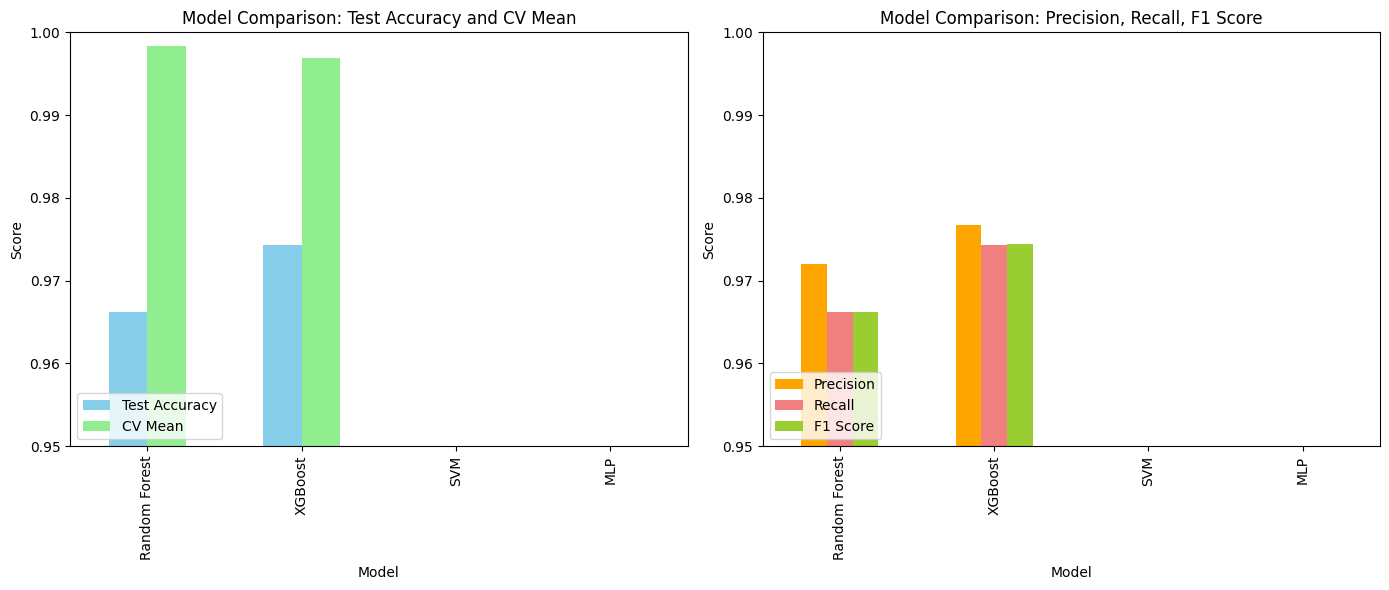

In [25]:
# Plotting the comparison for accuracy, cross-validation, and metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Using 1 row and 2 columns

# Plotting Test Accuracy and CV Mean
results.set_index('Model')[['Test Accuracy', 'CV Mean']].plot(
    kind='bar', 
    ax=axes[0], 
    color=['skyblue', 'lightgreen'], 
    legend=True
)
axes[0].set_title('Model Comparison: Test Accuracy and CV Mean')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].set_ylim(0.95, 1.0)  # Adjust if necessary
axes[0].legend(loc='lower left')

# Plotting Precision, Recall, F1 Score
results.set_index('Model')[['Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', 
    ax=axes[1], 
    color=['orange', 'lightcoral', 'yellowgreen'], 
    legend=True
)
axes[1].set_title('Model Comparison: Precision, Recall, F1 Score')
axes[1].set_ylabel('Score')
axes[1].set_xlabel('Model')
axes[1].set_ylim(0.95, 1.0)  # Adjust if necessary
axes[1].legend(loc='lower left')

plt.tight_layout()
plt.show()